# Truth deck
Compare truth deck sentences (n=374) to:
1. RegEx
2. NER
3. GPT

Sentences manually updated 5/6/23.

Similarity measure:
- Jaro-Winkler score (characters in common - better for shorter strings; output is ratio)

Decide whether to split the predictions by delimiter or calculate full span overlap

In [1]:
import pandas as pd
import numpy as np
from pyjarowinkler.distance import get_jaro_distance # to calculate a similarity score for a pair of strings

## Truth deck sentences

In [2]:
# df = pd.read_json('/nfs/turbo/isr-slafia/specimen/specimen_truth_deck.jsonl', lines=True).reset_index() # expose index
# df["manual_codes"] = ""

df = pd.read_csv('../data/truth_deck/truthdeck_specimen_results_in.csv')
# df["manual_codes"] = ""

# for index, row in df.iterrows():
#     specimens = []
#     spans = row["spans"]
#     for i in spans:
#         ref = i.get("text")
#         specimens.append(ref)
#     result = (", ".join(filter(None,specimens))) # may change delimiter based on comparison metric
#     df["manual_codes"][index] = result

# df['manual_codes'].replace("", "none", inplace=True) # replace empty codes with NA or none for similarity measure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             375 non-null    int64  
 1   text              375 non-null    object 
 2   meta              375 non-null    object 
 3   spans             375 non-null    object 
 4   tokens            375 non-null    object 
 5   manual_codes      375 non-null    object 
 6   regex_prediction  375 non-null    object 
 7   regex_simscore    375 non-null    float64
 8   ner_prediction    375 non-null    object 
 9   ner_simscore      375 non-null    float64
 10  gpt_prediction    375 non-null    object 
 11  gpt_simscore      375 non-null    float64
dtypes: float64(3), int64(1), object(8)
memory usage: 35.3+ KB


Describe the variety of labels in the truth deck

In [3]:
print("No specimens: ",len(df[df.manual_codes=='none']))
print("Has 1+ specimens: ",len(df[df.manual_codes!='none']))

No specimens:  184
Has 1+ specimens:  191


In [4]:
df_codes = df[df.manual_codes!='none']
print("Unique codes: ",df_codes.assign(manual_codes=df_codes.manual_codes.str.split(",").explode("manual_codes")).manual_codes.nunique())

Unique codes:  174


Calculate similarity scores

In [5]:
df['regex_simscore'] = [get_jaro_distance(x, y) for x, y in zip(df['manual_codes'], df['regex_prediction'])]
df['ner_simscore'] = [get_jaro_distance(x, y) for x, y in zip(df['manual_codes'], df['ner_prediction'])]
df['gpt_simscore'] = [get_jaro_distance(x, y) for x, y in zip(df['manual_codes'], df['gpt_prediction'])]

## RegEx sentences

In [6]:
# reg_res = pd.read_csv('/nfs/turbo/isr-slafia/specimen/truthdeck_specimen_results_pattern.csv')
# reg_res['specimen_prediction'].replace(np.nan, "none", inplace=True) # replace empty codes with none for string similarity measure
# reg_res = reg_res.drop(columns=['manual_codes'])
# df_res = pd.merge(df, reg_res, on=['index'])
# df_res['sim_score'] = [get_jaro_distance(x, y) for x, y in zip(df_res['manual_codes'], df_res['specimen_prediction'])]
# df_res = df_res.rename(columns={'text_x':'text','specimen_prediction':'regex_prediction','sim_score':'regex_simscore'})
# df_res.to_csv('/nfs/turbo/isr-slafia/specimen/truthdeck_specimen_results_pattern_v2.csv',index=False)
# df_res = df_res[['index','regex_prediction','regex_simscore']]
# df_res

In [7]:
# df_res.regex_simscore.describe()
df.regex_simscore.describe()

count    375.000000
mean       0.920240
std        0.221258
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: regex_simscore, dtype: float64

In [16]:
df.regex_simscore.median()

1.0

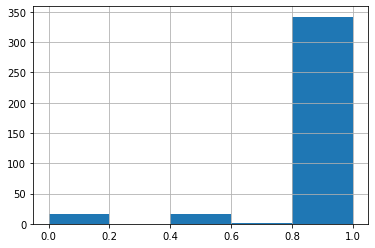

In [8]:
df.regex_simscore.hist(bins=5);
# df_res.regex_simscore.hist(bins=5);

## NER sentences

In [9]:
# ner_res = pd.read_csv('/nfs/turbo/isr-slafia/specimen/truthdeck_specimen_results_combined_ner.csv') # updated with new file from Kat
# ner_res['specimen_prediction'].replace(np.nan, "none", inplace=True) # replace empty codes with none for string similarity measure
# ner_res = ner_res[['index','specimen_prediction']]
# df_ner = pd.merge(df, ner_res, on=['index'])
# df_ner['sim_score'] = [get_jaro_distance(x, y) for x, y in zip(df_ner['manual_codes'], df_ner['specimen_prediction'])]
# df_ner = df_ner.rename(columns={'text_x':'text','specimen_prediction':'ner_prediction','sim_score':'ner_simscore'})
# df_ner.to_csv('/nfs/turbo/isr-slafia/specimen/truthdeck_specimen_results_ner_v2.csv',index=False)
# df_ner = df_ner[['index','ner_prediction','ner_simscore']]
# df_ner

In [10]:
df.ner_simscore.describe()

count    375.000000
mean       0.854000
std        0.323709
min        0.000000
25%        0.940000
50%        1.000000
75%        1.000000
max        1.000000
Name: ner_simscore, dtype: float64

In [20]:
df.ner_simscore.median()

1.0

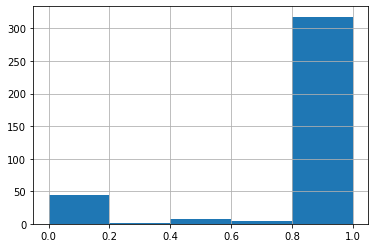

In [11]:
df.ner_simscore.hist(bins=5);

## GPT-3 sentences

In [12]:
# df_gpt = pd.read_csv('/nfs/turbo/isr-slafia/specimen/truthdeck_specimen_results_gpt.csv')
# df_gpt = df_gpt.rename(columns={'gpt_answer':'gpt_prediction','sim_score':'gpt_simscore'})
# df_gpt.to_csv('/nfs/turbo/isr-slafia/specimen/truthdeck_specimen_results_gpt_v2.csv',index=False)
# df_gpt = df_gpt[['index','gpt_prediction','gpt_simscore']]
# df_gpt

In [13]:
df.gpt_simscore.describe()

count    375.000000
mean       0.570427
std        0.432730
min        0.000000
25%        0.000000
50%        0.670000
75%        1.000000
max        1.000000
Name: gpt_simscore, dtype: float64

In [21]:
df.gpt_simscore.median()

0.67

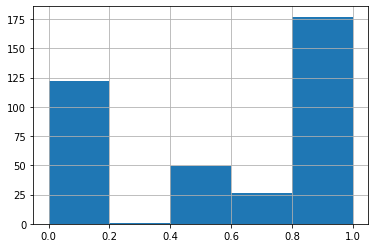

In [14]:
df.gpt_simscore.hist(bins=5);

Output a spreadsheet for comparison

In [15]:
# df_final = df.merge(df_res,on ='index').merge(df_ner,on ='index').merge(df_gpt,on ='index')
# df_final = df_final.drop(columns=['_input_hash','_task_hash','_is_binary','_view_id','answer','_timestamp'])
# df_final.to_csv('/nfs/turbo/isr-slafia/specimen/truthdeck_specimen_results_all.csv',index=False)
# df_final
df.to_csv('../data/truth_deck/truthdeck_specimen_results_out.csv',index=False)